In [ ]:
import numpy as np
from tensorflow import keras
import csv
import random
from matplotlib import pyplot as plt


# data augment
def rotation(array, angle):
    X = np.rot90(array, angle[0], axes=(0, 1))  # rotate in X-axis
    Y = np.rot90(X, angle[1], axes=(0, 2))  # rotate in Y'-axis
    Z = np.rot90(Y, angle[2], axes=(1, 2))  # rotate in Z"-axis
    return Z


def reflection(array, axis):
    if axis != -1:
        ref = np.flip(array, axis)
    else:
        ref = np.copy(array)
    return ref


def augment(x_train, y_train):
    print(np.size(x_train, 0))
    for i in range(0, np.size(x_train, 0)):
        angle = (random.randint(0, 3), random.randint(0, 3), random.randint(0, 3))
        rotated_data = rotation(x_train[i], angle)
        axis = random.randint(-1, 2)
        flipped_data = reflection(x_train[i], axis)
        # for j in range(0, 32, 2):
        #     plt.figure()
        #     plt.subplot(1, 3, 1)
        #     plt.imshow(rotated_data[j])
        #     plt.subplot(1, 3, 2)
        #     plt.imshow(flipped_data[j])
        #     plt.subplot(1, 3, 3)
        #     plt.imshow(x_train[i][j])
        #     plt.show()
        x_train = np.append(x_train, np.expand_dims(rotated_data, axis=0), axis=0)
        x_train = np.append(x_train, np.expand_dims(flipped_data, axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
    return x_train, y_train


def load_label():
    path = 'drive/MyDrive/dataset2/train_val.csv'
    y_train = np.loadtxt(path, int, delimiter=",", skiprows=1, usecols=1)
    print('Labels loaded')
    return y_train

import pandas as pd

# load feature original=1->返回增强的数据
def load_data(aug=False):
    focus = 16
    x_train = np.ones((365, 2 * focus, 2 * focus, 2 * focus))
    j = 0
    candidates = pd.read_csv('drive/MyDrive/dataset2/train_val.csv')['name']
    for c in candidates:
      a = 'drive/MyDrive/dataset2/train_val/' + c + '.npz'
      tmp = np.load(a)
      voxel = tmp['voxel']
      seg = tmp['seg']
      x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
      j = j + 1
    # for i in range(0, 480):
    #     a = 'drive/MyDrive/dataset2/train_val/candidate' + str(i) + '.npz'
    #     try:
    #         tmp = np.load(a)
    #         voxel = tmp['voxel']
    #         seg = tmp['seg']
    #         x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
    #         j = j + 1
    #     except:
    #         continue
    y_train = load_label()
    if aug is False:
        x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
        y_train = keras.utils.to_categorical(y_train, 2)
        return x_train, y_train
    x_train, y_train = augment(x_train, y_train)
    x_train, y_train = mix_up(x_train, y_train)
    x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
    y_train = keras.utils.to_categorical(y_train, 2)
    return x_train, y_train


def mix_up(x_train, y_train, increment=400):
    t = 0.5
    x = np.ones((increment, 32, 32, 32))
    y = np.ones(increment)
    i = 0
    size = np.size(x_train, 0)
    while i < increment:
        m = random.randint(0, size - 1)
        n = random.randint(0, size - 1)
        if y_train[m] == y_train[n]:
            x[i] = (t * x_train[m] + (1 - t) * x_train[n]).copy()
            y[i] = (t * y_train[m] + (1 - t) * y_train[n]).copy()
            i = i + 1
    # i = 0
    # for j in range(0, 32, 2):
    #     plt.figure()
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(x[i][j])
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(x_train[i][j])
    #     plt.show()
    final_x = np.append(x_train, x, axis=0)
    final_y = np.append(y_train, y)
    return final_x, final_y


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import h5py
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

NUM_CLASSES = 2
batch_size = 16
epoch = 30

x_train, y_train = load_data(True)
x_val, y_val = load_data()
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

# 

model = Sequential()
model.add(layers.Conv3D(32,(3,3,3),activation='relu',input_shape=(32,32,32,1),bias_initializer=Constant(0.01)))
model.add(layers.Conv3D(32,(3,3,3),activation='relu',bias_initializer=Constant(0.01)))
model.add(layers.MaxPooling3D((2,2,2)))
model.add(layers.Conv3D(64,(3,3,3),activation='relu'))
model.add(layers.Conv3D(64,(2,2,2),activation='relu'))
model.add(layers.MaxPooling3D((2,2,2)))
model.add(layers.Dropout(0.6))
model.add(layers.Flatten())
model.add(layers.Dense(256,'relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(128,'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,'softmax'))
model.summary()

model.compile(Adam(0.001),'categorical_crossentropy',['categorical_accuracy'])
history = model.fit(x_train,y_train,epochs=30,batch_size=32,verbose=1,validation_data=(x_val,y_val),callbacks=[EarlyStopping(patience=15)])



Labels loaded
365
Labels loaded
(1495, 32, 32, 32, 1) (1495, 2)
(365, 32, 32, 32, 1) (365, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 30, 30, 32)    896       
                                                                 
 conv3d_1 (Conv3D)           (None, 28, 28, 28, 32)    27680     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 14, 14, 32)   0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 12, 12, 12, 64)    55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 11, 11, 11, 64)    32832     
                                                                 
 max_pooling3d_1 (MaxPooling

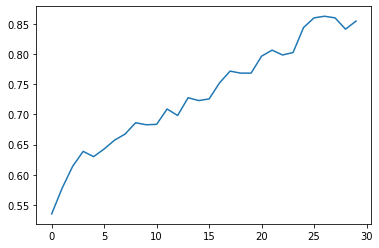

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])

In [ ]:
from pandas.io.parsers.python_parser import parser_defaults
import os
import numpy as np
# from mylib.densenet import get_compiled
import tensorflow as tf
import os
import pandas as pd
import sklearn.metrics

batch_size = 32
TEST_PATH = "drive/MyDrive/dataset2/test"
SUBMISSION_CSV = "drive/MyDrive/dataset2/result.csv"
TRAIN_CSV = "drive/MyDrive/dataset2/train_val.csv"

def load_test():
    x_test = np.ones((100, 32, 32, 32))
    i = 0
    path = TEST_PATH  
    path_list = os.listdir(path)
    path_list.sort()  
    for filename in path_list:
        tmp = np.load(os.path.join(path, filename))
        voxel = tmp['voxel']
        seg = tmp['seg']
        x_test[i] = (voxel * seg)[50 - 16:50 + 16, 50 - 16:50 + 16, 50 - 16:50 + 16]
        i = i + 1
    x_test = x_test.reshape(x_test.shape[0], 32, 32, 32, 1)
    return x_test

def save_sub(input_list):
  candidates = list()
  for c in os.listdir(TEST_PATH):
    candidates.append(c.split(".")[0])
  candidates.sort()
  data = {"name": candidates, "label": input_list[:, 1]}
  df = pd.DataFrame(data)
  df.to_csv(SUBMISSION_CSV)
  print('File saved')

x_test = load_test()

_, acc = model.evaluate(x_train, y_train)
print('training accuracy:', str(round(acc*100, 2))+'%')
true_labels = pd.read_csv('drive/MyDrive/dataset2/test_val.csv')['label']
print(list(true_labels))
# _, acc = model.evaluate(x_test, list(true_labels))
# print('testing accuracy:', str(round(acc*100, 2))+'%')


predicted_labels = model.predict(x_test, batch_size, verbose=1)[:, 1]
score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
print(score)
# model.predict_prob(img)

# for i in range(10, 30):
#     model_path = 'drive/MyDrive/tmp/weights0621.' + str(i) + '.h5'
#     model.load_weights(model_path)
#     res = model.predict(x_test, batch_size, verbose=1)

#     save_sub(res)
#     file = pd.read_csv(SUBMISSION_CSV)
    
#     predicted_labels = file['label']
#     true_labels = pd.read_csv('drive/MyDrive/dataset2/test_val.csv')['label']
#     print(true_labels)
#     score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
#     score_map[i] = score

# print(score_map)
# print(history.history.keys())







47/47 [==============================] - 1s 24ms/step - loss: 0.1760 - categorical_accuracy: 0.9431
training accuracy: 94.31%
[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
4/4 [==============================] - 0s 36ms/step
0.5968
